In [2]:
import os
import torch
from torchvision import datasets, transforms
import numpy as np
from sklearn.cluster import SpectralClustering
from sklearn.metrics import accuracy_score
import vision_transformer as vits
import vision_transformer as vits
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

In [122]:

#model = vits.__dict__['vit_small'](pretrained=True)
model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')


checkpoint = torch.load('/Users/rohitpotdukhe/Documents/checkpoint0080.pth', map_location=torch.device('cpu'))

'''new_state_dict = {}
for key, value in checkpoint['teacher'].items():
    name = key.replace('module.', '')  # Remove 'module.' prefix
    name = name.replace('backbone.', '')  # Remove 'backbone.' prefix
    new_state_dict[name] = value'''

state_dict = checkpoint['teacher']

 # remove `module.` prefix
state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
# remove `backbone.` prefix induced by multicrop wrapper
state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}

# Load the adjusted state dict into the model
model.load_state_dict(state_dict, strict=False)

Using cache found in /Users/rohitpotdukhe/.cache/torch/hub/facebookresearch_dino_main


_IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])

In [123]:
# Define the transformations (this should be the same as used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Example resize, adjust to your needs
    transforms.ToTensor(),
    # Add the same normalization as used during training
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset_dir = '/Users/rohitpotdukhe/Documents/val'

labeled_dataset = datasets.ImageFolder(test_dataset_dir, transform=transform)
labeled_loader = torch.utils.data.DataLoader(labeled_dataset, batch_size=32, shuffle=True)

# Initialize a list to store predictions
all_predictions = []

# Iterate over test dataset using DataLoader
for images, _ in labeled_loader:
    # Forward pass through the model
    with torch.no_grad():
        model.eval()
        outputs = model(images)

    # Append the predictions to the list
    all_predictions.append(outputs.cpu().numpy())

# Combine predictions into a single NumPy array
all_predictions = np.concatenate(all_predictions, axis=0)

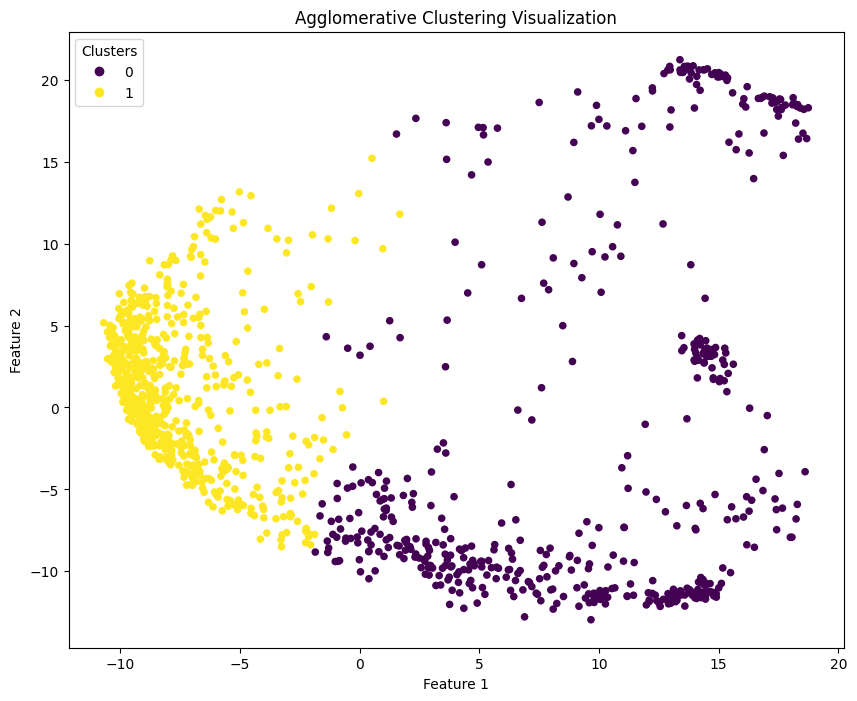

Accuracy: 0.5004269854824936
Normalized Mutual Information: 0.0007330721680991703
Adjusted Rand Index: -0.001636613633742197


In [124]:

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(all_predictions)

# Create an Agglomerative Clustering model
n_clusters = 2  # You need to specify the number of clusters
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)

# Fit the clustering model to your data
cluster_labels = agg_clustering.fit_predict(reduced_features)

# Visualize the clusters
plt.figure(figsize=(10, 8))

# Scatter plot of the cluster representations in 2D
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels, cmap='viridis', s=20)

# Customize the plot
plt.title('Agglomerative Clustering Visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(*scatter.legend_elements(), title='Clusters')
plt.show()

# Assuming you have ground truth labels for your test dataset
# Replace 'true_labels' with the actual ground truth labels
true_labels = labeled_dataset.targets

# Evaluate the clustering performance
accuracy = accuracy_score(true_labels, cluster_labels)

print(f"Accuracy: {accuracy}")